In [38]:
import os

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

In [39]:
def generate_data(mu, sigma, N, noise):
    x = np.linspace(-10, 10, N)
    data = (1/sigma/np.sqrt(2*jnp.pi))*jnp.exp(-0.5*(x-mu)**2/sigma**2) + noise*np.random.rand(N)
    return data

In [40]:
def generate_gaussian(mu, sigma, N):
    x = np.linspace(-10, 10, N)
    data = (1/sigma/np.sqrt(2*jnp.pi))*jnp.exp(-0.5*(x-mu)**2/sigma**2)
    return data

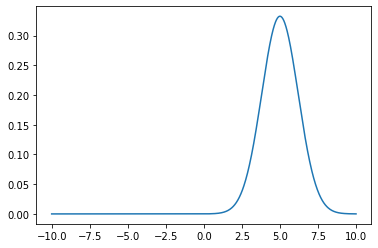

In [48]:
N = 1000
index = np.linspace(-10,10,N)
m = 5
s = 1.2
noise = 0.0

real_data = generate_data(m, s, N, noise)

plt.plot(index, real_data)
plt.show()

In [49]:
def model(N, data):
    mean = numpyro.sample('mean', dist.Uniform(-10,10))
    sigma = numpyro.sample('sigma', dist.Exponential(1.0))
    gaussian = numpyro.deterministic('gaussian', generate_gaussian(mu=mean, sigma=sigma, N=N))
    numpyro.sample('obs', dist.Normal(gaussian), obs=data)

In [50]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)

# Run NUTS.
kernel = NUTS(model, adapt_step_size=True)
num_samples = 4000
mcmc = MCMC(kernel, num_chains=1, num_warmup=1000, num_samples=num_samples)
mcmc.run(rng_key, N, real_data)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|█| 5000/5000 [00:08<00:00, 603.25it/s, 7 steps of size 5.55e-01. a



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mean      4.96      1.03      5.01      3.81      6.15    695.80      1.00
     sigma      1.51      0.67      1.36      0.64      2.35   1225.19      1.00

Number of divergences: 0


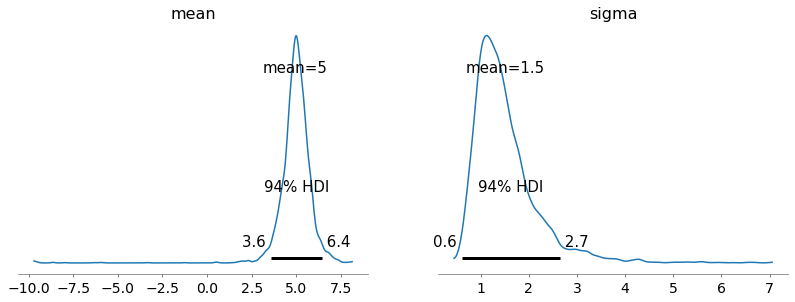

In [51]:
ds = az.from_numpyro(mcmc)

ds.posterior

params = ['mean', 'sigma']
az.plot_posterior(ds, var_names=params)
plt.show()

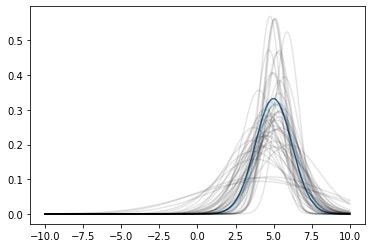

In [52]:
plt.plot(index, real_data)
plt.plot(index, ds.posterior.gaussian[0,:50].T, color='k', alpha=0.1)
plt.show()

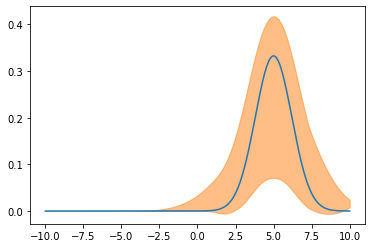

In [53]:
plt.plot(index, real_data)
az.plot_hdi(index, ds.posterior.gaussian)
plt.show()